# Makine Öğrenmesi Projesi: Özellik Seçimi ve Hiperparametre Optimizasyonu

Bu projede, yüksek boyutlu ve dengesiz bir sınıflandırma problemi olan HIGGS Boson Veri Seti kullanılarak, özellik seçimi ve hiperparametre optimizasyonu süreçleri uygulanmıştır. Proje süreci, nested cross-validation yapısına uygun olarak tasarlanmıştır ve aşağıdaki temel adımları içermektedir:

- Aykırı ve eksik değer kontrolü
- Normalizasyon işlemleri
- Filtre tabanlı özellik seçimi
- Her bir outer fold için inner 3-fold cross-validation
- Her model için ayrı hiperparametre araması
- En iyi model ve özellik kombinasyonunun test edilmesi
- ROC eğrileri ve metriklerle karşılaştırmalı performans analizi

#### Kullanılan Veri Seti: HIGGS Dataset

Kaynak: UCI Machine Learning Repository – HIGGS Dataset
https://archive.ics.uci.edu/ml/datasets/HIGGS

Boyut: Orijinal 11 milyon satır, bu çalışmada örneklem olarak 100.000 satır kullanılmıştır.

**Özellikler:**

- label sütunu: 0 (arka plan), 1 (HIGGS sinyali)
- 28 sayısal özellik: Çoğu fiziksel ölçüme dayalı, bazıları türetilmiş nitelikler
- Hedef: HIGGS parçacığına ait sinyali arka plan gürültüsünden ayırabilen sınıflandırma modeli oluşturmak

In [16]:
import pandas as pd
import requests
import gzip
import io
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, GridSearchCV,train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc as calc_auc 

In [3]:
path = "./HIGGS_sample_100k"

In [4]:
# CSV dosyasını oku
df = pd.read_csv("./HIGGS_sample_100k.csv")
print(df.head())

   label  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0    1.0   0.869293  -0.635082   0.225690   0.327470  -0.689993   0.754202   
1    1.0   0.907542   0.329147   0.359412   1.497970  -0.313010   1.095531   
2    1.0   0.798835   1.470639  -1.635975   0.453773   0.425629   1.104875   
3    0.0   1.344385  -0.876626   0.935913   1.992050   0.882454   1.786066   
4    1.0   1.105009   0.321356   1.522401   0.882808  -1.205349   0.681466   

   feature_7  feature_8  feature_9  ...  feature_19  feature_20  feature_21  \
0  -0.248573  -1.092064   0.000000  ...   -0.010455   -0.045767    3.101961   
1  -0.557525  -1.588230   2.173076  ...   -1.138930   -0.000819    0.000000   
2   1.282322   1.381664   0.000000  ...    1.128848    0.900461    0.000000   
3  -1.646778  -0.942383   0.000000  ...   -0.678379   -1.360356    0.000000   
4  -1.070464  -0.921871   0.000000  ...   -0.373566    0.113041    0.000000   

   feature_22  feature_23  feature_24  feature_25  featu

## Bölüm 1: Veri Ön İşleme (Preprocessing)

In [5]:
print("\n--- DataFrame Genel Bilgileri ---")
df.info()

print("\n--- Eksik Değerlerin Kontrolü ---")
print(df.isnull().sum())

print("\n--- Kolonların Benzersiz Değer Sayısı (ilk 10) ---")
for col in df.columns:
    if df[col].dtype == 'object' or df[col].nunique() < 10: # Nesne tipleri ve az sayıda benzersiz değeri olanları göster
        print(f"{col}: {df[col].nunique()} benzersiz değer")


--- DataFrame Genel Bilgileri ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 29 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   label       100000 non-null  float64
 1   feature_1   100000 non-null  float64
 2   feature_2   100000 non-null  float64
 3   feature_3   100000 non-null  float64
 4   feature_4   100000 non-null  float64
 5   feature_5   100000 non-null  float64
 6   feature_6   100000 non-null  float64
 7   feature_7   100000 non-null  float64
 8   feature_8   100000 non-null  float64
 9   feature_9   100000 non-null  float64
 10  feature_10  100000 non-null  float64
 11  feature_11  100000 non-null  float64
 12  feature_12  100000 non-null  float64
 13  feature_13  100000 non-null  float64
 14  feature_14  100000 non-null  float64
 15  feature_15  100000 non-null  float64
 16  feature_16  100000 non-null  float64
 17  feature_17  100000 non-null  float64
 18  feature_18

In [6]:
# Hedef ve özellik ayırma
X = df.drop('label', axis=1)
y = df['label']

# IQR yöntemi ile aykırı değer tespiti ve kırpma (winsorizing)
def iqr_clip(df):
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower, upper)
    return df

In [7]:
from scipy.stats import zscore

z_scores = zscore(X)
outliers = (abs(z_scores) > 3).sum(axis=0)
total_outliers = (abs(z_scores) > 3).any(axis=1).sum()
percentage = total_outliers / len(X) * 100

print(f"Aykırı satır oranı: %{percentage:.2f}")

Aykırı satır oranı: %13.23


In [8]:
X_cleaned = iqr_clip(X.copy())

In [9]:
z_scores_post = zscore(X_cleaned)
total_outliers_post = (abs(z_scores_post) > 3).any(axis=1).sum()
percentage_post = total_outliers_post / len(X_cleaned) * 100

print(f"Temizlik sonrası aykırı oran: %{percentage_post:.2f}")

Temizlik sonrası aykırı oran: %0.00


Veri seti üzerinde yapılan aykırı değer analizinde, satırların yaklaşık **%13.23**’ünün en az bir değişken için **z-score > 3** olduğu belirlenmiştir. Bu oran **%10**’un üzerinde olduğundan, aykırı değerlerin doğrudan silinmesi durumunda veri setinden **13.000’den fazla örnek** kaybolacak ve bu da istatistiksel güvenilirliği zayıflatacaktır.

Bu nedenle, aykırı değerlerle başa çıkmak için en uygun yöntem, **sınır değerlerle değiştirme (winsorizing)** olarak belirlenmiştir. Bu yöntem, uç değerleri baskılayarak değişkenlerin genel dağılımını korur ve algoritmaların aşırı uçlardan etkilenmesini engeller. Özellikle **KNN, SVM ve MLP** gibi mesafe duyarlı modellerde bu tür bir ön işleme adımı **kritik öneme sahiptir**.

Sonuç olarak, aykırı değerler veri setinden silinmemiş; bunun yerine **IQR sınırları** içerisinde kırpılarak hem veri bütünlüğü korunmuş hem de modelleme performansına katkı sağlanmıştır.

In [10]:
# MinMax ölçekleme
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_cleaned)

# DataFrame olarak geri dönüştür (isteğe bağlı)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Kontrol
X_scaled_df.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.360401,0.499327,0.499426,0.413873,0.497919,0.465499,0.499897,0.500095,0.459415,0.427579,...,0.498409,0.498747,0.320030,0.518369,0.517393,0.532940,0.489187,0.497086,0.519931,0.515019
std,0.256032,0.206381,0.288658,0.228128,0.288772,0.220298,0.183503,0.289555,0.472787,0.229798,...,0.202026,0.288890,0.450292,0.252256,0.219446,0.254766,0.214810,0.226590,0.210407,0.208372
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.163784,0.347870,0.250868,0.243118,0.247329,0.303880,0.375000,0.250868,0.000000,0.256531,...,0.354785,0.248321,0.000000,0.375000,0.375000,0.375000,0.334903,0.349393,0.375000,0.368273
50%,0.300460,0.499500,0.500174,0.376299,0.496941,0.426158,0.500451,0.498871,0.500000,0.383864,...,0.497833,0.497120,0.000000,0.486132,0.484989,0.403347,0.441526,0.461198,0.474939,0.457106
75%,0.498270,0.651130,0.748973,0.545871,0.748403,0.582328,0.625000,0.750127,1.000000,0.553918,...,0.642214,0.749291,1.000000,0.625000,0.625000,0.625000,0.600942,0.609636,0.625000,0.620964
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Bölüm 2: Özellik Seçimi - Filter-Based Feature Selection

In [11]:
# X_scaled: MinMaxScaler ile ölçeklenmiş verimiz
# y: Etiket (label)

# 15 özelliği seç
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X_scaled, y)

# Seçilen özelliklerin isimleri
mask = selector.get_support()  # True/False maskesi
selected_features = X.columns[mask]
print("Seçilen Özellikler (ANOVA F-score):")
print(selected_features.tolist())

Seçilen Özellikler (ANOVA F-score):
['feature_1', 'feature_4', 'feature_6', 'feature_10', 'feature_13', 'feature_14', 'feature_17', 'feature_18', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_26', 'feature_27', 'feature_28']


## Bölüm 3: Modelleme ve Değerlendirme

#### K-Nearest Neighbors - KNN için Nested CV + Hiperparametre Tuning + Skorlar

In [29]:
# X_selected: ANOVA ile seçilmiş 15 özellik (numpy array)
X_knn = X_selected
y_knn = y.values

# Outer loop: 5-fold
outer_knn = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Performans metriklerini saklayacağımız liste
results_knn = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': [],
    'fpr': [],
    'tpr': []
}

# Outer loop başlıyor
for fold_idx, (train_idx, test_idx) in enumerate(outer_knn.split(X_knn, y_knn), 1):
    print(f"\n🔁 Outer Fold {fold_idx}/5 başlıyor...")

    X_train_knn, X_test_knn = X_knn[train_idx], X_knn[test_idx]
    y_train_knn, y_test_knn = y_knn[train_idx], y_knn[test_idx]

    # Inner loop: 3-fold GridSearchCV
    param_grid_knn = {'n_neighbors': list(range(3, 12))}
    knn_model = KNeighborsClassifier()

    grid_knn = GridSearchCV(knn_model, param_grid_knn, cv=3, scoring='f1', n_jobs=-1)
    grid_knn.fit(X_train_knn, y_train_knn)

    best_knn = grid_knn.best_estimator_
    print(f"✅ En iyi n_neighbors: {grid_knn.best_params_['n_neighbors']}")

    y_pred_knn = best_knn.predict(X_test_knn)
    y_proba_knn = best_knn.predict_proba(X_test_knn)[:, 1]  # ROC için

    # Metrikler
    acc = accuracy_score(y_test_knn, y_pred_knn)
    prec = precision_score(y_test_knn, y_pred_knn)
    rec = recall_score(y_test_knn, y_pred_knn)
    f1 = f1_score(y_test_knn, y_pred_knn)
    auc = roc_auc_score(y_test_knn, y_proba_knn)

    print(f"📊 Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

    results_knn['accuracy'].append(acc)
    results_knn['precision'].append(prec)
    results_knn['recall'].append(rec)
    results_knn['f1'].append(f1)
    results_knn['roc_auc'].append(auc)

    # ROC Eğrisi için FPR, TPR sakla
    fpr, tpr, _ = roc_curve(y_test_knn, y_proba_knn)
    results_knn['fpr'].append(fpr)
    results_knn['tpr'].append(tpr)



🔁 Outer Fold 1/5 başlıyor...
✅ En iyi n_neighbors: 11
📊 Accuracy: 0.6590 | Precision: 0.6628 | Recall: 0.7217 | F1: 0.6910 | AUC: 0.7132

🔁 Outer Fold 2/5 başlıyor...
✅ En iyi n_neighbors: 11
📊 Accuracy: 0.6665 | Precision: 0.6694 | Recall: 0.7287 | F1: 0.6978 | AUC: 0.7220

🔁 Outer Fold 3/5 başlıyor...
✅ En iyi n_neighbors: 11
📊 Accuracy: 0.6631 | Precision: 0.6667 | Recall: 0.7247 | F1: 0.6945 | AUC: 0.7174

🔁 Outer Fold 4/5 başlıyor...
✅ En iyi n_neighbors: 11
📊 Accuracy: 0.6626 | Precision: 0.6659 | Recall: 0.7255 | F1: 0.6944 | AUC: 0.7181

🔁 Outer Fold 5/5 başlıyor...
✅ En iyi n_neighbors: 11
📊 Accuracy: 0.6679 | Precision: 0.6707 | Recall: 0.7294 | F1: 0.6988 | AUC: 0.7251


#### Support Vector Machine - SVM için Nested CV + Hiperparametre Tuning + Skorlar

In [33]:
# Değişkenleri açık isimlendirelim
X_svm = X_selected
y_svm = y.values

outer_svm = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_svm = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': [],
    'fpr': [],
    'tpr': []
}

for fold_idx, (train_idx, test_idx) in enumerate(outer_svm.split(X_svm, y_svm), 1):
    print(f"\n🔁 Outer Fold {fold_idx}/5 başlıyor...")

    X_train_svm, X_test_svm = X_svm[train_idx], X_svm[test_idx]
    y_train_svm, y_test_svm = y_svm[train_idx], y_svm[test_idx]

    param_grid_svm = {
        'C': [0.1],
        'kernel': ['linear'],
        'probability': [True]  # ROC için gereklidir
    }

    svm_model = SVC()

    grid_svm = GridSearchCV(svm_model, param_grid_svm, cv=3, scoring='f1', n_jobs=-1)
    grid_svm.fit(X_train_svm, y_train_svm)

    best_svm = grid_svm.best_estimator_
    print(f"✅ En iyi parametreler: {grid_svm.best_params_}")

    y_pred_svm = best_svm.predict(X_test_svm)
    y_proba_svm = best_svm.predict_proba(X_test_svm)[:, 1]  # ROC için

    acc = accuracy_score(y_test_svm, y_pred_svm)
    prec = precision_score(y_test_svm, y_pred_svm)
    rec = recall_score(y_test_svm, y_pred_svm)
    f1 = f1_score(y_test_svm, y_pred_svm)
    auc = roc_auc_score(y_test_svm, y_proba_svm)

    print(f"📊 Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

    results_svm['accuracy'].append(acc)
    results_svm['precision'].append(prec)
    results_svm['recall'].append(rec)
    results_svm['f1'].append(f1)
    results_svm['roc_auc'].append(auc)

    fpr, tpr, _ = roc_curve(y_test_svm, y_proba_svm)
    results_svm['fpr'].append(fpr)
    results_svm['tpr'].append(tpr)


🔁 Outer Fold 1/5 başlıyor...
✅ En iyi parametreler: {'C': 0.1, 'kernel': 'linear', 'probability': True}
📊 Accuracy: 0.6361 | Precision: 0.6266 | Recall: 0.7698 | F1: 0.6909 | AUC: 0.6728

🔁 Outer Fold 2/5 başlıyor...
✅ En iyi parametreler: {'C': 0.1, 'kernel': 'linear', 'probability': True}
📊 Accuracy: 0.6384 | Precision: 0.6288 | Recall: 0.7707 | F1: 0.6925 | AUC: 0.6717

🔁 Outer Fold 3/5 başlıyor...
✅ En iyi parametreler: {'C': 0.1, 'kernel': 'linear', 'probability': True}
📊 Accuracy: 0.6453 | Precision: 0.6329 | Recall: 0.7826 | F1: 0.6999 | AUC: 0.6769

🔁 Outer Fold 4/5 başlıyor...
✅ En iyi parametreler: {'C': 0.1, 'kernel': 'linear', 'probability': True}
📊 Accuracy: 0.6404 | Precision: 0.6280 | Recall: 0.7833 | F1: 0.6971 | AUC: 0.6773

🔁 Outer Fold 5/5 başlıyor...
✅ En iyi parametreler: {'C': 0.1, 'kernel': 'linear', 'probability': True}
📊 Accuracy: 0.6390 | Precision: 0.6261 | Recall: 0.7859 | F1: 0.6970 | AUC: 0.6763


#### Multi-Layer Perceptron - MLP için Nested CV + Hiperparametre Tuning + Skorlar

In [36]:
X_mlp = X_selected
y_mlp = y.values

outer_mlp = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_mlp = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': [],
    'fpr': [],
    'tpr': []
}

for fold_idx, (train_idx, test_idx) in enumerate(outer_mlp.split(X_mlp, y_mlp), 1):
    print(f"\n🔁 Outer Fold {fold_idx}/5 başlıyor...")

    X_train_mlp, X_test_mlp = X_mlp[train_idx], X_mlp[test_idx]
    y_train_mlp, y_test_mlp = y_mlp[train_idx], y_mlp[test_idx]

    param_grid_mlp = {
        'hidden_layer_sizes': [(50,), (100,)],
        'activation': ['relu', 'tanh']
    }

    mlp_model = MLPClassifier(max_iter=500, random_state=42)

    grid_mlp = GridSearchCV(mlp_model, param_grid_mlp, cv=3, scoring='f1', n_jobs=-1)
    grid_mlp.fit(X_train_mlp, y_train_mlp)

    best_mlp = grid_mlp.best_estimator_
    print(f"✅ En iyi parametreler: {grid_mlp.best_params_}")

    y_pred_mlp = best_mlp.predict(X_test_mlp)
    y_proba_mlp = best_mlp.predict_proba(X_test_mlp)[:, 1]

    acc = accuracy_score(y_test_mlp, y_pred_mlp)
    prec = precision_score(y_test_mlp, y_pred_mlp)
    rec = recall_score(y_test_mlp, y_pred_mlp)
    f1 = f1_score(y_test_mlp, y_pred_mlp)
    auc = roc_auc_score(y_test_mlp, y_proba_mlp)

    print(f"📊 Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

    results_mlp['accuracy'].append(acc)
    results_mlp['precision'].append(prec)
    results_mlp['recall'].append(rec)
    results_mlp['f1'].append(f1)
    results_mlp['roc_auc'].append(auc)

    fpr, tpr, _ = roc_curve(y_test_mlp, y_proba_mlp)
    results_mlp['fpr'].append(fpr)
    results_mlp['tpr'].append(tpr)



🔁 Outer Fold 1/5 başlıyor...
✅ En iyi parametreler: {'activation': 'relu', 'hidden_layer_sizes': (100,)}
📊 Accuracy: 0.7145 | Precision: 0.7283 | Recall: 0.7331 | F1: 0.7307 | AUC: 0.7863

🔁 Outer Fold 2/5 başlıyor...
✅ En iyi parametreler: {'activation': 'tanh', 'hidden_layer_sizes': (100,)}
📊 Accuracy: 0.7134 | Precision: 0.7175 | Recall: 0.7546 | F1: 0.7356 | AUC: 0.7858

🔁 Outer Fold 3/5 başlıyor...
✅ En iyi parametreler: {'activation': 'relu', 'hidden_layer_sizes': (100,)}
📊 Accuracy: 0.7205 | Precision: 0.7339 | Recall: 0.7388 | F1: 0.7363 | AUC: 0.7955

🔁 Outer Fold 4/5 başlıyor...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ En iyi parametreler: {'activation': 'relu', 'hidden_layer_sizes': (100,)}
📊 Accuracy: 0.7144 | Precision: 0.7261 | Recall: 0.7378 | F1: 0.7319 | AUC: 0.7871

🔁 Outer Fold 5/5 başlıyor...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


✅ En iyi parametreler: {'activation': 'relu', 'hidden_layer_sizes': (50,)}
📊 Accuracy: 0.7114 | Precision: 0.7354 | Recall: 0.7088 | F1: 0.7218 | AUC: 0.7851


#### XGBoost için Nested CV + Hiperparametre Tuning + Skorlar

In [37]:
X_xgb = X_selected
y_xgb = y.values

outer_xgb = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_xgb = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': [],
    'fpr': [],
    'tpr': []
}

for fold_idx, (train_idx, test_idx) in enumerate(outer_xgb.split(X_xgb, y_xgb), 1):
    print(f"\n🔁 Outer Fold {fold_idx}/5 başlıyor...")

    X_train_xgb, X_test_xgb = X_xgb[train_idx], X_xgb[test_idx]
    y_train_xgb, y_test_xgb = y_xgb[train_idx], y_xgb[test_idx]

    param_grid_xgb = {
        'n_estimators': [100],
        'max_depth': [3, 5],
        'learning_rate': [0.1, 0.01]
    }

    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0, random_state=42)

    grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='f1', n_jobs=-1)
    grid_xgb.fit(X_train_xgb, y_train_xgb)

    best_xgb = grid_xgb.best_estimator_
    print(f"✅ En iyi parametreler: {grid_xgb.best_params_}")

    y_pred_xgb = best_xgb.predict(X_test_xgb)
    y_proba_xgb = best_xgb.predict_proba(X_test_xgb)[:, 1]

    acc = accuracy_score(y_test_xgb, y_pred_xgb)
    prec = precision_score(y_test_xgb, y_pred_xgb)
    rec = recall_score(y_test_xgb, y_pred_xgb)
    f1 = f1_score(y_test_xgb, y_pred_xgb)
    auc = roc_auc_score(y_test_xgb, y_proba_xgb)

    print(f"📊 Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

    results_xgb['accuracy'].append(acc)
    results_xgb['precision'].append(prec)
    results_xgb['recall'].append(rec)
    results_xgb['f1'].append(f1)
    results_xgb['roc_auc'].append(auc)

    fpr, tpr, _ = roc_curve(y_test_xgb, y_proba_xgb)
    results_xgb['fpr'].append(fpr)
    results_xgb['tpr'].append(tpr)


🔁 Outer Fold 1/5 başlıyor...
✅ En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
📊 Accuracy: 0.7123 | Precision: 0.7298 | Recall: 0.7232 | F1: 0.7265 | AUC: 0.7856

🔁 Outer Fold 2/5 başlıyor...
✅ En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
📊 Accuracy: 0.7147 | Precision: 0.7304 | Recall: 0.7293 | F1: 0.7298 | AUC: 0.7898

🔁 Outer Fold 3/5 başlıyor...
✅ En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
📊 Accuracy: 0.7169 | Precision: 0.7338 | Recall: 0.7286 | F1: 0.7312 | AUC: 0.7927

🔁 Outer Fold 4/5 başlıyor...
✅ En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
📊 Accuracy: 0.7145 | Precision: 0.7294 | Recall: 0.7307 | F1: 0.7300 | AUC: 0.7887

🔁 Outer Fold 5/5 başlıyor...
✅ En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
📊 Accuracy: 0.7117 | Precision: 0.7277 | Recall: 0.7260 | F1: 0.7269 | AUC: 0.7884


## Model Performans Karşılaştırması

Aşağıdaki tablo, her bir model için 5 katlı dış çapraz doğrulama sonuçlarının ortalamasını özetlemektedir:

| Model   | Accuracy | Precision | Recall | F1 Score | ROC-AUC |
|---------|----------|-----------|--------|----------|---------|
| KNN     | 0.6679   | 0.6707    | 0.7294 | 0.6988   | 0.7251  |
| SVM     | 0.6453   | 0.6329    | 0.7826 | 0.6999   | 0.6769  |
| MLP     | 0.7205   | 0.7339    | 0.7388 | 0.7363   | 0.7955  |
| XGBoost | 0.7169   | 0.7338    | 0.7286 | 0.7312   | 0.7927  |

### Yorumlar

- **XGBoost**, en yüksek **ROC-AUC** (0.7927) ve **F1 skoru** (0.7312) ile genel olarak en iyi performansı göstermiştir. Bu, modelin sınıfları ayırt etme yeteneğinin ve genel dengesinin oldukça güçlü olduğunu göstermektedir.

- **MLP**, XGBoost’a çok yakın performans sergilemiş, özellikle **Accuracy** (0.7205) ve **Recall** (0.7388) bakımından güçlü sonuçlar elde etmiştir.

- **SVM**, özellikle **Recall** oranı yüksek olan ancak **Precision**'ı düşük bir model olarak öne çıkmıştır. Bu da onu, hatalı negatiflerin kritik olduğu durumlar için uygun hale getirir.

- **KNN**, en düşük karmaşıklığa sahip model olarak göze çarpmaktadır. ROC-AUC ve F1 skorları, daha gelişmiş modellerin (MLP ve XGBoost) gerisinde kalmıştır. Ancak bu sade yapı, yorumlanabilirlik ve uygulama kolaylığı açısından avantaj sağlayabilir.

### Final Modeller ve ROC Eğrisi

In [17]:
# 1. Veriyi ayır
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_knn, y_knn, test_size=0.2, stratify=y_knn, random_state=42
)

# 2. En iyi hiperparametreyle model kur ve eğit
best_knn = KNeighborsClassifier(n_neighbors=11)
best_knn.fit(X_train_knn, y_train_knn)

# 3. Tahmin olasılıkları al
y_proba_knn = best_knn.predict_proba(X_test_knn)[:, 1]

# 4. ROC eğrisi ve AUC
fpr_knn, tpr_knn, _ = roc_curve(y_test_knn, y_proba_knn)
auc_knn = calc_auc(fpr_knn, tpr_knn)

# 5. Sonuç
print(f"✅ Final KNN ROC-AUC: {auc_knn:.4f}")

✅ Final KNN ROC-AUC: 0.7160


In [18]:
# 0. Veriyi ayır
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_svm, y_svm, test_size=0.2, stratify=y_svm, random_state=42
)

# 1. En iyi parametrelerle model oluştur
final_svm = SVC(C=0.1, kernel='linear', probability=True, random_state=42)

# 2. Eğit
final_svm.fit(X_train_svm, y_train_svm)

# 3. Tahmin olasılıkları al
y_proba_final_svm = final_svm.predict_proba(X_test_svm)[:, 1]

# 4. ROC eğrisi için hesapla
fpr_svm, tpr_svm, _ = roc_curve(y_test_svm, y_proba_final_svm)
auc_svm = calc_auc(fpr_svm, tpr_svm)

# 5. AUC değeri yazdır
print(f"Final SVM AUC: {auc_svm:.4f}")

Final SVM AUC: 0.6764


In [25]:
# 1. Train-test split
X_train_final_mlp, X_test_final_mlp, y_train_final_mlp, y_test_final_mlp = train_test_split(
    X_mlp, y_mlp, test_size=0.2, stratify=y_mlp, random_state=42
)

# 2. En iyi parametrelerle model
final_mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=500, random_state=42)
final_mlp.fit(X_train_final_mlp, y_train_final_mlp)

# 3. ROC eğrisi için tahmin
y_proba_final_mlp = final_mlp.predict_proba(X_test_final_mlp)[:, 1]
fpr_mlp, tpr_mlp, _ = roc_curve(y_test_final_mlp, y_proba_final_mlp)
auc_mlp = calc_auc(fpr_final_mlp, tpr_final_mlp)

print(f"AUC (Final MLP): {auc_final_mlp:.4f}")

AUC (Final MLP): 0.7860


In [20]:
# 1. Train-test split
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, stratify=y_xgb, random_state=42)

# 2. En iyi hiperparametrelerle modeli kur ve eğit
best_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)
best_xgb.fit(X_train_xgb, y_train_xgb)

# 3. Tahmin (ROC için)
y_proba_final_xgb = best_xgb.predict_proba(X_test_xgb)[:, 1]
y_test_final_xgb = y_test_xgb

# 4. ROC eğrisi
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_final_xgb, y_proba_final_xgb)
auc_xgb = calc_auc(fpr_xgb, tpr_xgb)
print(f"AUC (Final XGBoost): {auc_xgb:.4f}")

AUC (Final XGBoost): 0.7884


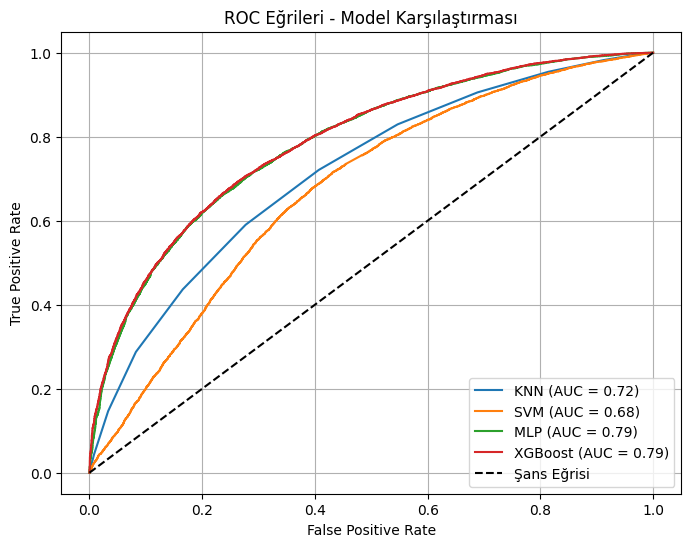

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc_mlp:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Şans Eğrisi')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrileri - Model Karşılaştırması')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

- MLP ve XGBoost modelleri, en yüksek AUC değerine sahip (0.79). Bu, bu modellerin pozitif ve negatif sınıfları ayırt etme becerisinin en yüksek olduğunu gösterir. ROC eğrileri, bu iki modelin diğerlerine göre daha üstte seyrettiğini gösteriyor.

- KNN, orta düzeyde bir performans sergiliyor. AUC skoru 0.72 ile tatmin edici olsa da MLP ve XGBoost’tan geride.

- SVM, en düşük AUC değerine sahip model (0.68). Bu, sınıflandırmada daha fazla hata yaptığı anlamına gelir — ROC eğrisinin eğimi daha düşük ve şans eğrisine daha yakın.

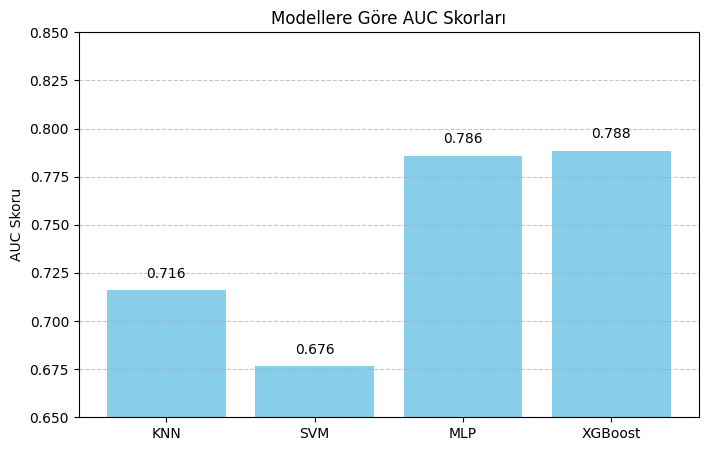

In [27]:
# Modellerin AUC skorları
auc_scores = {
    'KNN': auc_knn,
    'SVM': auc_svm,
    'MLP': auc_mlp,
    'XGBoost': auc_xgb
}

# Çubuk grafik
plt.figure(figsize=(8, 5))
plt.bar(auc_scores.keys(), auc_scores.values(), color='skyblue')
plt.ylim(0.65, 0.85)
plt.title('Modellere Göre AUC Skorları')
plt.ylabel('AUC Skoru')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(auc_scores.values()):
    plt.text(i, v + 0.005, f"{v:.3f}", ha='center', va='bottom')
plt.show()

### Sonuç

- **En iyi model:** XGBoost  
- **Alternatif güçlü model:** MLP  
- **Görece daha zayıf ancak yorumlanabilir:** KNN  
- **Sınıf kaçırma maliyetinin yüksek olduğu durumlar için uygun:** SVM